### Library Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost import XGBClassifier



import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SMOTEN,SVMSMOTE,KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler,NearMiss
from imblearn.combine import SMOTEENN,SMOTETomek

from collections import Counter

from sklearn.cluster import DBSCAN



### Data Import

In [2]:
random_state = 23873

In [3]:
dt = pd.read_excel(r'CA_BC.xlsx').T
dt.columns = dt.iloc[0]
dt = dt.iloc[1:]
dt['Label'] = dt.Label.map({'E':1,'A':0})

In [7]:
dt.drop_duplicates(keep='first',inplace=True)
for x in dt.select_dtypes(include=['object']).columns:
    dt[x] = dt[x].astype('float64')
dt.columns = [str(x) for x in dt.columns]
dt = dt.select_dtypes(include=['float64','int64'])

In [8]:
# Columns to not rename
excluded = dt.columns[~dt.columns.duplicated(keep=False)]

# An incrementer
import itertools
inc = itertools.count().__next__

# A renamer
def ren(name):
    return f"{name}{inc()}" if name not in excluded else name

# Use inside rename()
dt.rename(columns=ren,inplace=True)

### Baseline Modelling

In [9]:
from lazypredict.Supervised import LazyClassifier
features = dt.copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:40<00:00,  1.39s/it]


In [11]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.92,0.90,0.90,0.92,4.63
BaggingClassifier,0.87,0.88,0.88,0.88,3.86
AdaBoostClassifier,0.92,0.88,0.88,0.92,11.15
XGBClassifier,0.87,0.81,0.81,0.87,2.71
ExtraTreesClassifier,0.85,0.80,0.80,0.84,0.86
RidgeClassifierCV,0.85,0.80,0.80,0.84,0.63
RidgeClassifier,0.85,0.80,0.80,0.84,0.66
LogisticRegression,0.85,0.80,0.80,0.84,0.83
DecisionTreeClassifier,0.79,0.78,0.78,0.80,0.90


In [36]:
# print(models.iloc[:, :-1].reset_index().to_latex(index=False))

## Linear Models

### Remove Co-Linear Fields

In [17]:
# https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/
corr = dt.corr()

In [18]:
# sns.heatmap(corr)

In [19]:
# Create correlation matrix
corr_matrix = corr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Would drop {len(to_drop)} fields")

Would drop 912 fields


In [20]:
features = dt.drop(to_drop, axis=1).copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_corr,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:36<00:00,  1.26s/it]


In [21]:
models_corr

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.92,0.88,0.88,0.92,12.44
LGBMClassifier,0.87,0.84,0.84,0.87,2.84
XGBClassifier,0.87,0.81,0.81,0.87,1.91
ExtraTreesClassifier,0.87,0.81,0.81,0.87,0.66
RidgeClassifierCV,0.85,0.80,0.80,0.84,0.57
RidgeClassifier,0.85,0.80,0.80,0.84,0.52
BaggingClassifier,0.85,0.80,0.80,0.84,3.93
LogisticRegression,0.82,0.75,0.75,0.81,0.71
LinearDiscriminantAnalysis,0.82,0.75,0.75,0.81,0.92


In [45]:
diff_1 = pd.merge(models,models_corr,left_index=True, right_index=True)[['F1 Score_x','F1 Score_y']]
diff_1['diff'] = abs(diff_1['F1 Score_x'] - diff_1['F1 Score_y'])
diff_1['diff'].mean()

0.02098075209774462

### Check Variance Inflation Factor

In [46]:
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# vif_info = pd.DataFrame()
# vif_info['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
# vif_info['Column'] = features.columns
# vif_info.sort_values('VIF', ascending=False)

### Min Max Scaling

In [47]:
# x_train_MinMax = MinMaxScaler().fit_transform(x_train)
# clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
# models_min_max,predictions=clf.fit(x_train_MinMax, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


In [61]:
features = dt.drop(to_drop, axis=1).copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(MinMaxScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)

clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_min_max,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:27<00:00,  1.04it/s]


In [221]:
models_min_max.to_csv('min_max.csv')

In [69]:
print(models_min_max.iloc[:, :-1].reset_index().to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
                        Model &  Accuracy &  Balanced Accuracy &  ROC AUC &  F1 Score \\
\midrule
           AdaBoostClassifier &      0.92 &               0.88 &     0.88 &      0.92 \\
               LGBMClassifier &      0.87 &               0.84 &     0.84 &      0.87 \\
                XGBClassifier &      0.87 &               0.81 &     0.81 &      0.87 \\
         ExtraTreesClassifier &      0.87 &               0.81 &     0.81 &      0.87 \\
            RidgeClassifierCV &      0.85 &               0.80 &     0.80 &      0.84 \\
              RidgeClassifier &      0.85 &               0.80 &     0.80 &      0.84 \\
            BaggingClassifier &      0.85 &               0.80 &     0.80 &      0.84 \\
           LogisticRegression &      0.82 &               0.75 &     0.75 &      0.81 \\
   LinearDiscriminantAnalysis &      0.82 &               0.75 &     0.75 &      0.81 \\
       RandomForestClassifier &      0.82 &               0.75 &     

In [63]:
diff_1 = pd.merge(models,models_min_max,left_index=True, right_index=True)[['F1 Score_x','F1 Score_y']]
diff_1['diff'] = abs(diff_1['F1 Score_x'] - diff_1['F1 Score_y'])
diff_1['diff'].mean()

0.021643908560489273

In [64]:
# x_train_Standard = StandardScaler().fit_transform(x_train)
# clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
# models_standard,predictions=clf.fit(x_train_Standard, x_test, y_train, y_test)

In [66]:
features = dt.drop(to_drop, axis=1).copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)

clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_standard,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


In [67]:
models_standard

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.92,0.88,0.88,0.92,10.60
LGBMClassifier,0.87,0.84,0.84,0.87,2.31
XGBClassifier,0.87,0.81,0.81,0.87,1.34
ExtraTreesClassifier,0.87,0.81,0.81,0.87,0.45
RidgeClassifierCV,0.85,0.80,0.80,0.84,0.34
RidgeClassifier,0.85,0.80,0.80,0.84,0.33
BaggingClassifier,0.85,0.80,0.80,0.84,2.68
LogisticRegression,0.82,0.75,0.75,0.81,0.48
LinearDiscriminantAnalysis,0.82,0.75,0.75,0.81,0.54


In [68]:
diff_1 = pd.merge(models,models_standard,left_index=True, right_index=True)[['F1 Score_x','F1 Score_y']]
diff_1['diff'] = abs(diff_1['F1 Score_x'] - diff_1['F1 Score_y'])
diff_1['diff'].mean()

0.019972377477193493

### Deep Dive on Scaled Data

In [21]:
from sklearn.neighbors import NearestCentroid

features = dt.drop(to_drop, axis=1).copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
# Creating the Nearest Centroid Classifier
model = LogisticRegression()
 
# Training the classifier
model.fit(x_train, y_train.values.ravel())
 
# Printing Accuracy on Training and Test sets
print(f"Training Set Score : {model.score(x_train, y_train) * 100} %")
print(f"Test Set Score : {model.score(x_test, y_test) * 100} %")
 
# Printing classification report of classifier on the test set set data
print(f"Model Classification Report : \n{classification_report(y_test, model.predict(x_test))}")

imp = pd.DataFrame(data = {'fields':features.columns,'importance':model.coef_[0]}).sort_values(by='importance',axis=0, ascending=False, inplace=False)
imp[imp.importance.abs() >= imp[imp.importance!=0].importance.median()]

Training Set Score : 100.0 %
Test Set Score : 82.05128205128204 %
Model Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.83      0.93      0.88        27

    accuracy                           0.82        39
   macro avg       0.81      0.75      0.77        39
weighted avg       0.82      0.82      0.81        39



,fields,importance
9795,LOC90784,0.02
14125,KBF2,0.02
9909,LOC100294335,0.02
5791,SAXO1,0.01
11066,NAALADL2,0.01
...,...,...
9670,XRCC6P5,-0.02
17026,TCTEX1D1,-0.02
2538,C5ORF60,-0.02
15111,SERPINB11,-0.02


#### Selecting top 10 would not give best result because of negative importance

In [22]:
cols = imp.head(10).fields.values.tolist() + ['Label']
features = dt.drop(to_drop, axis=1)[cols].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
# Creating the Nearest Centroid Classifier
model = LogisticRegression()
 
# Training the classifier
model.fit(x_train, y_train.values.ravel())
 
# Printing Accuracy on Training and Test sets
print(f"Training Set Score : {model.score(x_train, y_train) * 100} %")
print(f"Test Set Score : {model.score(x_test, y_test) * 100} %")
 
# Printing classification report of classifier on the test set set data
print(f"Model Classification Report : \n{classification_report(y_test, model.predict(x_test))}")

Training Set Score : 97.75280898876404 %
Test Set Score : 79.48717948717949 %
Model Classification Report : 
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.83      0.89      0.86        27

    accuracy                           0.79        39
   macro avg       0.76      0.74      0.75        39
weighted avg       0.79      0.79      0.79        39



### Recursive Feature Importance

In [23]:
from sklearn import datasets
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.ensemble import  RandomForestClassifier
import pandas as pd
pd.set_option("display.precision", 8)

In [24]:
def feat_select_log_reg(col):
    features = dt[col].copy()
    target = features.pop('Label')

    from sklearn.pipeline import Pipeline
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', LogisticRegression())
    ])
    
    scoring = {
               'balanced_accuracy':'balanced_accuracy',
               'f1_macro':'f1_macro',
               'precision_macro':'precision_macro',
               'recall_macro':'recall_macro',
              }

    # clf=RandomForestClassifier(n_estimators =10, random_state = 42,class_weight='balanced')
    clf = LogisticRegression()
    output = cross_validate(pipe, features, target, cv=4, scoring = scoring, return_estimator =True)

    imp = pd.DataFrame(data = {'fields':features.columns,'importance':np.mean([estimator.steps[1][1].coef_[0] for estimator in output['estimator']],axis=0)}).sort_values(by='importance',axis=0, ascending=False, inplace=False)
    imp = pd.concat([imp[imp.importance <= imp[imp.importance < 0].importance.median()],
    imp[imp.importance >= imp[imp.importance > 0].importance.median()]],axis=0)
    print(f"{len(col)} columns produced macro recall of {output['test_recall_macro'].mean()}")
    return {
            'features': len(col),
            'cols':col,
            'medians': (imp[imp.importance < 0].importance.median(),imp[imp.importance > 0].importance.median()),
            'balanced_accuracy' :output['test_balanced_accuracy'].mean(),
            'f1_macro':output['test_f1_macro'].mean(),
            'precision_macro':output['test_precision_macro'].mean(),
            'recall_macro':output['test_recall_macro'].mean(),
            'balanced_accuracy_std':output['test_balanced_accuracy'].std(),
            'f1_macro_std':output['test_f1_macro'].std(),
            'precision_macro_std':output['test_precision_macro'].std(),
            'recall_macro_std':output['test_recall_macro'].std(),
            'next' : imp,
            'next_columns' : [x for x in imp.fields.values] + ['Label']
            }

In [25]:
col = dt.drop(to_drop, axis=1).columns
features = [0,1]
result= []
while len(set(features[-5:])) != 1:
    res = feat_select_log_reg(col)
    result.append(res)
    features.append(res['features'])
    col = res['next_columns']

19620 columns produced macro recall of 0.7917748917748918
9575 columns produced macro recall of 0.9409090909090909
4788 columns produced macro recall of 0.9647727272727273
2395 columns produced macro recall of 0.9761363636363637
1199 columns produced macro recall of 0.9875
601 columns produced macro recall of 0.9875
302 columns produced macro recall of 1.0
152 columns produced macro recall of 0.9761363636363637
77 columns produced macro recall of 0.9875
40 columns produced macro recall of 0.9761363636363637
21 columns produced macro recall of 0.975
12 columns produced macro recall of 0.9397727272727272
7 columns produced macro recall of 0.8622294372294372
5 columns produced macro recall of 0.8443181818181817
3 columns produced macro recall of 0.7579545454545455
3 columns produced macro recall of 0.7579545454545455
3 columns produced macro recall of 0.7579545454545455
3 columns produced macro recall of 0.7579545454545455
3 columns produced macro recall of 0.7579545454545455


In [ ]:
result

#### Fisher

In [85]:
##

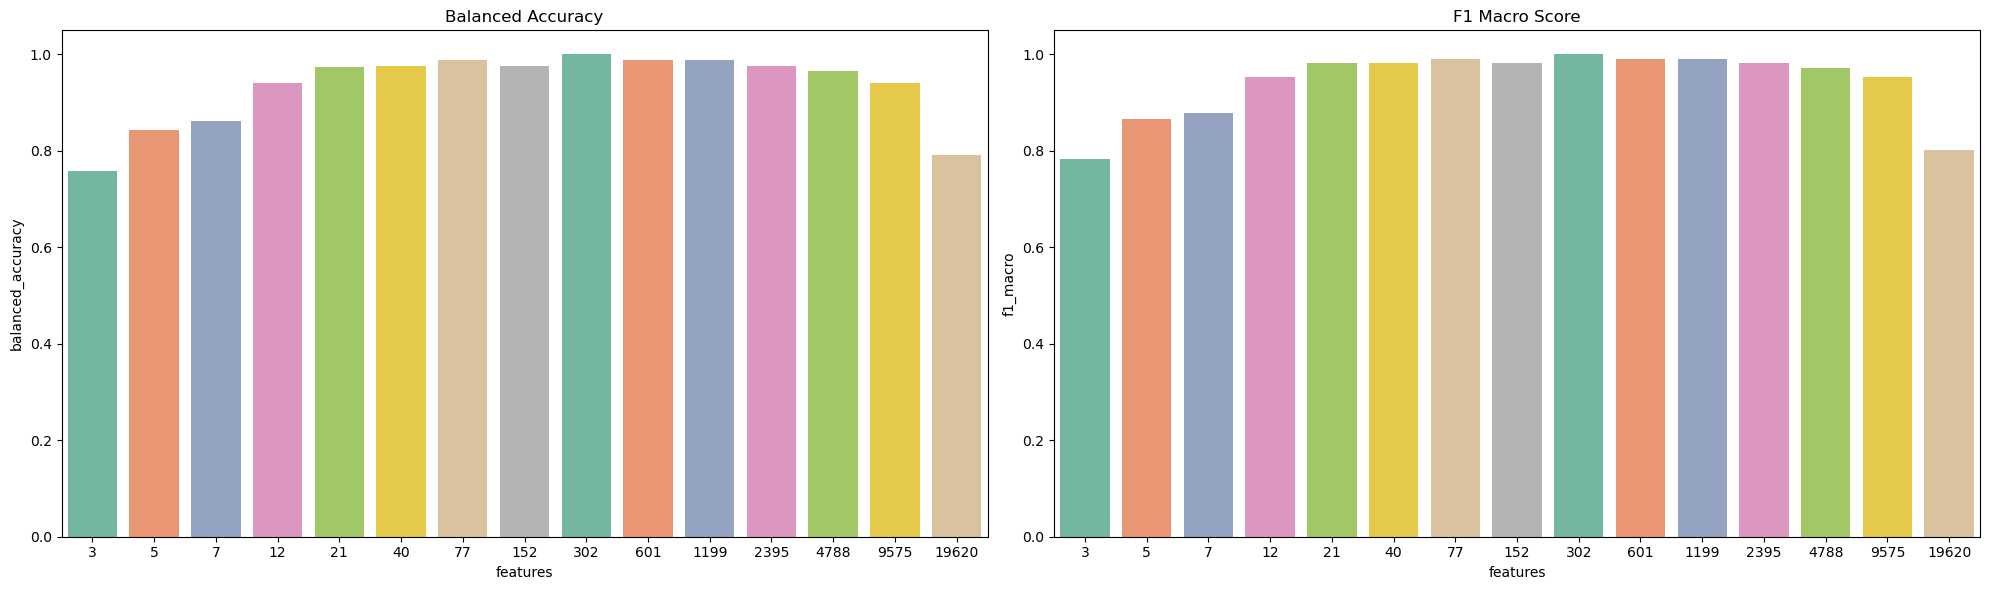

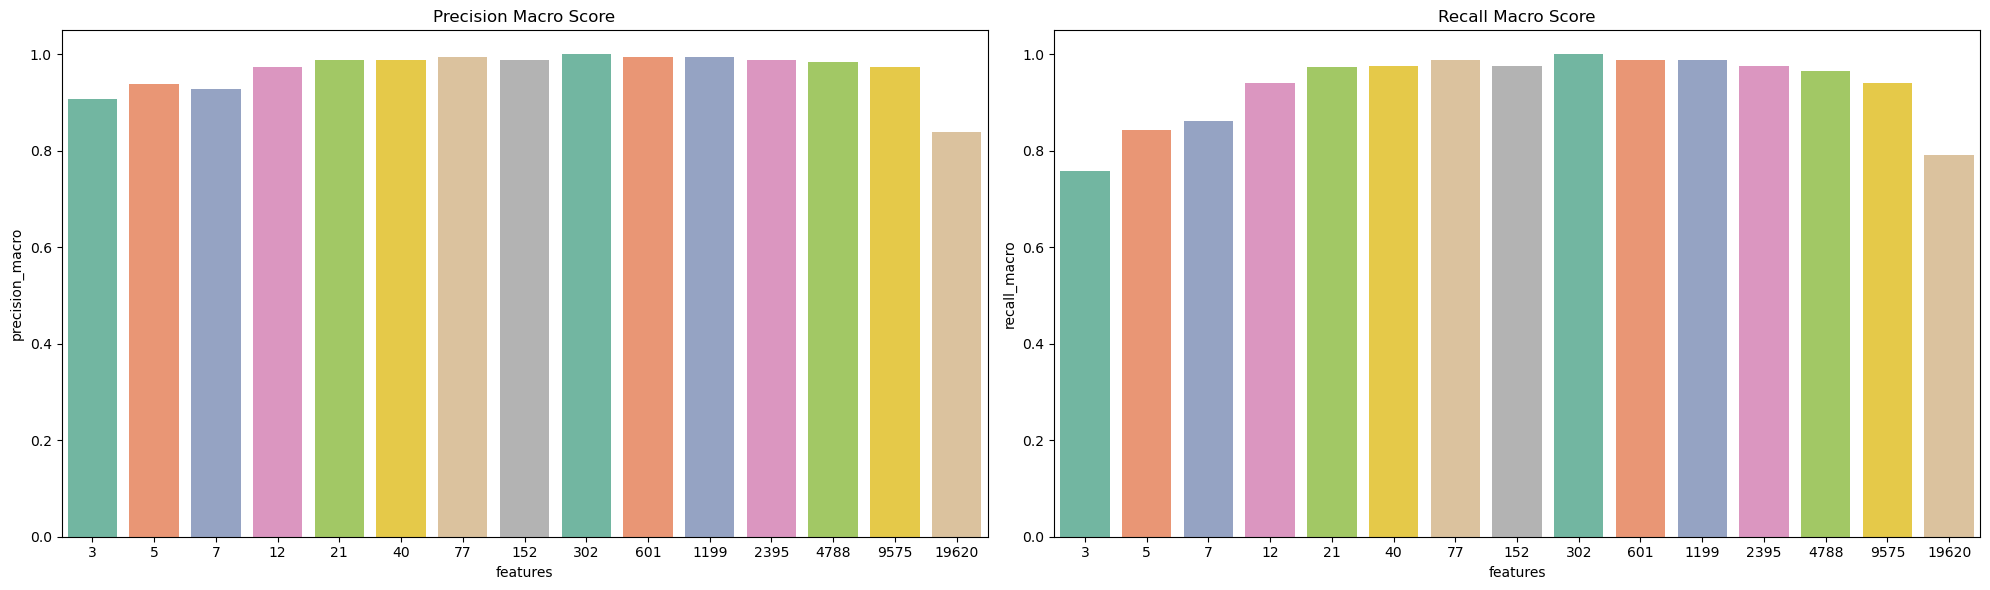

In [26]:
cv_res = pd.DataFrame(data = {'features': [res['features'] for res in result],
'balanced_accuracy': [res['balanced_accuracy'] for res in result],
'f1_macro': [res['f1_macro'] for res in result],
'precision_macro': [res['precision_macro'] for res in result],
'recall_macro': [res['recall_macro'] for res in result]})

plt.rcParams["figure.figsize"] = [20.00, 6.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.barplot(x = 'features',y = 'balanced_accuracy',data = cv_res, palette = "Set2",ax=axes[0]).set(title='Balanced Accuracy')
sns.barplot(x = 'features',y = 'f1_macro',data = cv_res, palette = "Set2",ax=axes[1]).set(title='F1 Macro Score')
plt.show()


plt.rcParams["figure.figsize"] = [20.00, 6.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.barplot(x = 'features',y = 'precision_macro',data = cv_res, palette = "Set2",ax=axes[0]).set(title='Precision Macro Score')
sns.barplot(x = 'features',y = 'recall_macro',data = cv_res, palette = "Set2",ax=axes[1]).set(title='Recall Macro Score')
plt.show()

In [27]:
dd = result[[res['features'] for res in result].index(21)]['cols']

In [28]:
features = dt[dd].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
# Creating the Nearest Centroid Classifier
model = LogisticRegression()
 
# Training the classifier
model.fit(x_train, y_train.values.ravel())
 
# Printing Accuracy on Training and Test sets
print(f"Training Set Score : {model.score(x_train, y_train) * 100} %")
print(f"Test Set Score : {model.score(x_test, y_test) * 100} %")
 
# Printing classification report of classifier on the test set set data
print(f"Model Classification Report : \n{classification_report(y_test, model.predict(x_test))}")

Training Set Score : 100.0 %
Test Set Score : 94.87179487179486 %
Model Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.96      0.96      0.96        27

    accuracy                           0.95        39
   macro avg       0.94      0.94      0.94        39
weighted avg       0.95      0.95      0.95        39



In [29]:
features = dt[dd].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 25.47it/s]


In [30]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.95,0.96,0.96,0.95,0.01
LabelPropagation,0.95,0.96,0.96,0.95,0.02
LabelSpreading,0.95,0.96,0.96,0.95,0.01
CalibratedClassifierCV,0.97,0.96,0.96,0.97,0.03
LinearSVC,0.95,0.94,0.94,0.95,0.01
LogisticRegression,0.95,0.94,0.94,0.95,0.02
RidgeClassifierCV,0.95,0.94,0.94,0.95,0.02
RandomForestClassifier,0.95,0.94,0.94,0.95,0.26
ExtraTreesClassifier,0.95,0.94,0.94,0.95,0.19


#### Pearson Correlation

In [210]:
def cor_selector(X, y):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-10:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [211]:
features = dt.copy()
target = features.pop('Label')
cor_support, cor_feature = cor_selector(features, target)
print(str(len(cor_feature)), 'selected features')

10 selected features


In [212]:
features = dt[cor_feature + ['Label']].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)

In [213]:
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_filter_corr,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 34.33it/s]


In [215]:
models_filter_corr.to_csv('pearson.csv')

In [216]:
# features = dt[cor_feature + ['Label']].copy()
# target = features.pop('Label')
# x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
# # Creating the Nearest Centroid Classifier
# model = LogisticRegression()
 
# # Training the classifier
# model.fit(x_train, y_train.values.ravel())
 
# # Printing Accuracy on Training and Test sets
# print(f"Training Set Score : {model.score(x_train, y_train) * 100} %")
# print(f"Test Set Score : {model.score(x_test, y_test) * 100} %")
 
# # Printing classification report of classifier on the test set set data
# print(f"Model Classification Report : \n{classification_report(y_test, model.predict(x_test))}")

In [217]:
# features = dt[cor_feature + ['Label']].copy()
# target = features.pop('Label')
# x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.3,random_state=random_state)
# clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
# models,predictions=clf.fit(x_train, x_test, y_train, y_test)

In [218]:
# models

In [219]:
diff_1 = pd.merge(models_min_max,models_filter_corr,left_index=True, right_index=True)
diff_1['diff'] = diff_1['F1 Score_y'] - diff_1['F1 Score_x']
diff_1['diff_1'] = abs(diff_1['F1 Score_y'] - diff_1['F1 Score_x'])
diff_1['diff_1'].mean()

0.17818632107900823

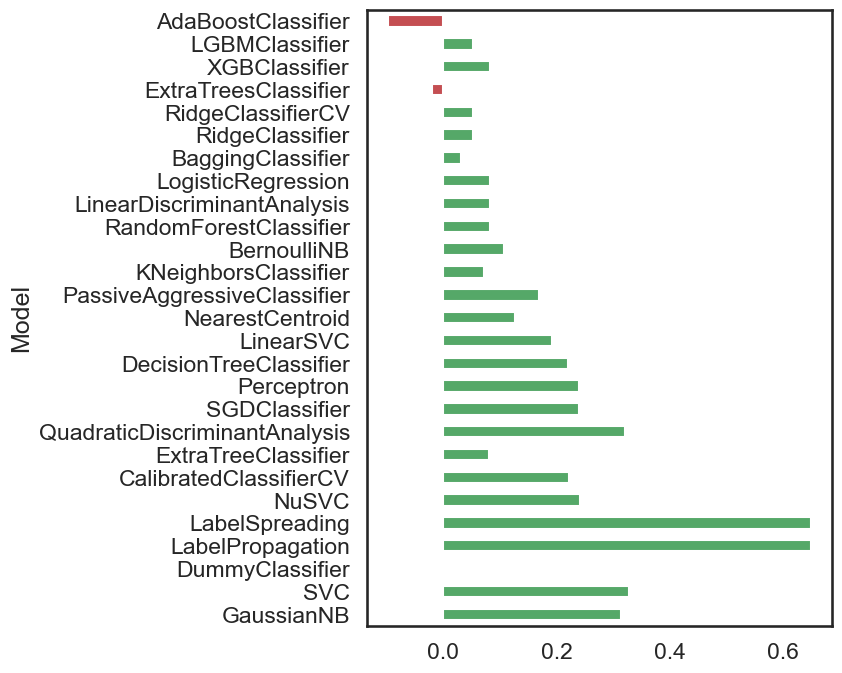

In [220]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,8)
diff_1.iloc[::-1]['diff'].plot(kind='barh',
                    color=(diff_1.iloc[::-1]['diff'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.savefig('pearson correlation new.eps',bbox_inches = 'tight',dpi=1200,transparent= True, format='eps')

#### Chi - Square Features

In [177]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

features = dt.drop(to_drop, axis=1).copy()
target = features.pop('Label')

X_norm = MinMaxScaler().fit_transform(features)
chi_selector = SelectKBest(chi2, k=10)
chi_selector.fit(X_norm, target)
chi_support = chi_selector.get_support()
chi_feature = features.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

10 selected features


In [178]:
# features = dt[chi_feature + ['Label']].copy()
# target = features.pop('Label')
# x_train, x_test, y_train, y_test = train_test_split(MinMaxScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
# # Creating the Nearest Centroid Classifier
# model = LogisticRegression()
 
# # Training the classifier
# model.fit(x_train, y_train.values.ravel())
 
# # Printing Accuracy on Training and Test sets
# print(f"Training Set Score : {model.score(x_train, y_train) * 100} %")
# print(f"Test Set Score : {model.score(x_test, y_test) * 100} %")
 
# # Printing classification report of classifier on the test set set data
# print(f"Model Classification Report : \n{classification_report(y_test, model.predict(x_test))}")

In [179]:
features = dt[chi_feature + ['Label']].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_chi,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 55.84it/s]


In [209]:
models_chi.to_csv('chi.csv')

In [181]:
diff_1 = pd.merge(models_min_max,models_chi,left_index=True, right_index=True)
diff_1['diff'] = diff_1['F1 Score_y'] - diff_1['F1 Score_x']
diff_1['diff_1'] = abs(diff_1['F1 Score_y'] - diff_1['F1 Score_x'])
diff_1['diff_1'].mean()

0.15436794757264619

In [182]:
diff_1

,Accuracy_x,Balanced Accuracy_x,ROC AUC_x,F1 Score_x,Time Taken_x,Accuracy_y,Balanced Accuracy_y,ROC AUC_y,F1 Score_y,Time Taken_y,diff,diff_1
Model,,,,,,,,,,,,
AdaBoostClassifier,0.92,0.88,0.88,0.92,11.20,0.87,0.84,0.84,0.87,0.07,-0.05,0.05
LGBMClassifier,0.87,0.84,0.84,0.87,2.39,0.85,0.82,0.82,0.85,0.02,-0.02,0.02
XGBClassifier,0.87,0.81,0.81,0.87,1.37,0.87,0.86,0.86,0.87,0.02,0.01,0.01
ExtraTreesClassifier,0.87,0.81,0.81,0.87,0.44,0.90,0.86,0.86,0.89,0.07,0.03,0.03
RidgeClassifierCV,0.85,0.80,0.80,0.84,0.36,0.90,0.83,0.83,0.89,0.00,0.05,0.05
RidgeClassifier,0.85,0.80,0.80,0.84,0.33,0.90,0.83,0.83,0.89,0.02,0.05,0.05
BaggingClassifier,0.85,0.80,0.80,0.84,2.74,0.77,0.76,0.76,0.78,0.02,-0.07,0.07
LogisticRegression,0.82,0.75,0.75,0.81,0.51,0.90,0.86,0.86,0.89,0.01,0.08,0.08
LinearDiscriminantAnalysis,0.82,0.75,0.75,0.81,0.55,0.90,0.83,0.83,0.89,0.00,0.08,0.08


In [183]:
# sns.barplot(x=diff_1['diff'], y=diff_1.index, orient='h')
# # sns.barplot(x=diff_1['diff'], y=diff_1.index, palette="vlag")
# # ax2.axhline(0, color="k", clip_on=False)

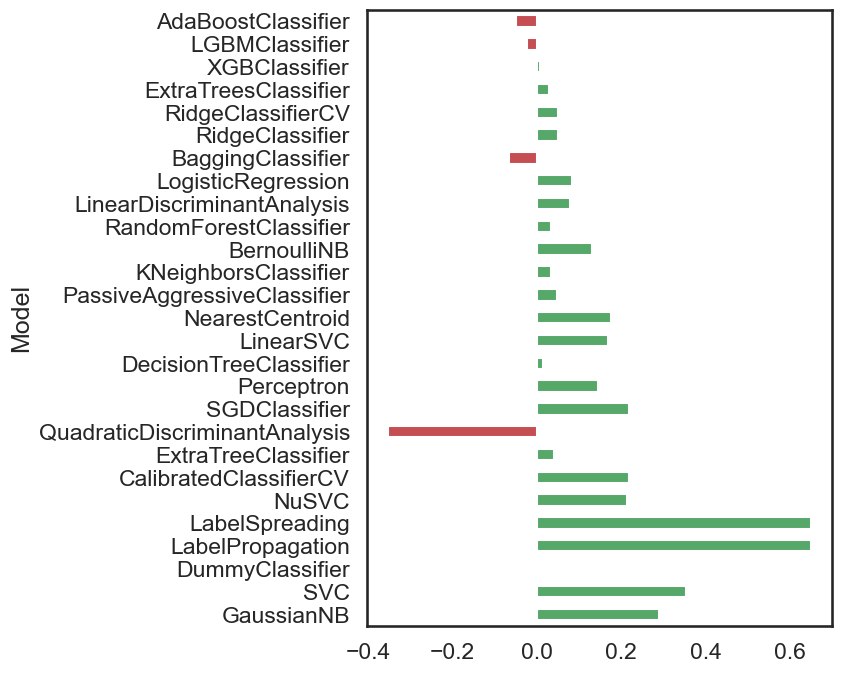

In [184]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,8)
diff_1.iloc[::-1]['diff'].plot(kind='barh',
                    color=(diff_1.iloc[::-1]['diff'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.savefig('pearson correlation new.eps',bbox_inches = 'tight',dpi=1200,transparent= True, format='eps')

In [161]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set_theme(style="white", context="talk")
# rs = np.random.RandomState(8)

# # Set up the matplotlib figure
# f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

# # Generate some sequential data
# x = np.array(list("ABCDEFGHIJ"))
# y1 = np.arange(1, 11)
# sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
# ax1.axhline(0, color="k", clip_on=False)
# ax1.set_ylabel("Sequential")

# # Center the data to make it diverging
# y2 = y1 - 5.5
# sns.barplot(x=x, y=y2, palette="vlag", ax=ax2)
# ax2.axhline(0, color="k", clip_on=False)
# ax2.set_ylabel("Diverging")

# # Randomly reorder the data to make it qualitative
# y3 = rs.choice(y1, len(y1), replace=False)
# sns.barplot(x=x, y=y3, palette="deep", ax=ax3)
# ax3.axhline(0, color="k", clip_on=False)
# ax3.set_ylabel("Qualitative")

# # Finalize the plot
# sns.despine(bottom=True)
# plt.setp(f.axes, yticks=[])
# plt.tight_layout(h_pad=2)

#### RFE

In [191]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

features = dt.drop(to_drop, axis=1).copy()
target = features.pop('Label')
X_norm = MinMaxScaler().fit_transform(features)

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=1000, verbose=5)
rfe_selector.fit(X_norm, target)

Fitting estimator with 19619 features.
Fitting estimator with 18619 features.
Fitting estimator with 17619 features.
Fitting estimator with 16619 features.
Fitting estimator with 15619 features.
Fitting estimator with 14619 features.
Fitting estimator with 13619 features.
Fitting estimator with 12619 features.
Fitting estimator with 11619 features.
Fitting estimator with 10619 features.
Fitting estimator with 9619 features.
Fitting estimator with 8619 features.
Fitting estimator with 7619 features.
Fitting estimator with 6619 features.
Fitting estimator with 5619 features.
Fitting estimator with 4619 features.
Fitting estimator with 3619 features.
Fitting estimator with 2619 features.
Fitting estimator with 1619 features.
Fitting estimator with 619 features.


RFE(estimator=LogisticRegression(), n_features_to_select=10, step=1000,
    verbose=5)

In [192]:
rfe_support = rfe_selector.get_support()
rfe_feature = features.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

10 selected features


In [201]:
# features = dt[rfe_feature + ['Label']].copy()
# target = features.pop('Label')
# x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
# # Creating the Nearest Centroid Classifier
# model = LogisticRegression()
 
# # Training the classifier
# model.fit(x_train, y_train.values.ravel())
 
# # Printing Accuracy on Training and Test sets
# print(f"Training Set Score : {model.score(x_train, y_train) * 100} %")
# print(f"Test Set Score : {model.score(x_test, y_test) * 100} %")
 
# # Printing classification report of classifier on the test set set data
# print(f"Model Classification Report : \n{classification_report(y_test, model.predict(x_test))}")

In [202]:
features = dt[rfe_feature + ['Label']].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_rfe,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 53.84it/s]


In [208]:
models_rfe.to_csv('rfe.csv')

In [204]:
diff_1 = pd.merge(models_min_max,models_rfe,left_index=True, right_index=True)
diff_1['diff'] = diff_1['F1 Score_y'] - diff_1['F1 Score_x']
diff_1['diff_1'] = abs(diff_1['F1 Score_y'] - diff_1['F1 Score_x'])
diff_1['diff_1'].mean()

0.21250451695346573

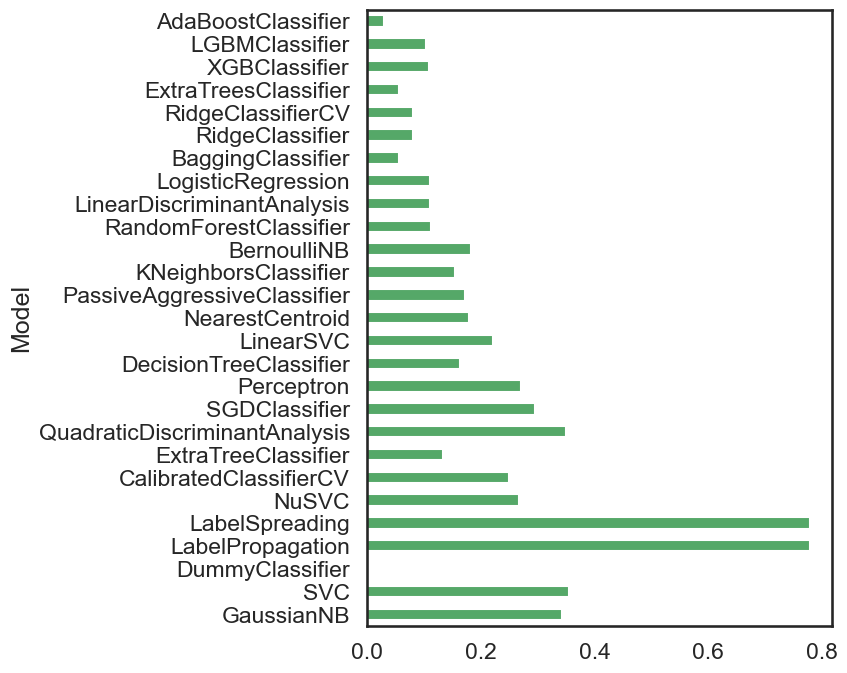

In [206]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,8)
diff_1.iloc[::-1]['diff'].plot(kind='barh',
                    color=(diff_1.iloc[::-1]['diff'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.savefig('rfe.eps',bbox_inches = 'tight',dpi=1200,transparent= True, format='eps')

#### Information Gain

In [129]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

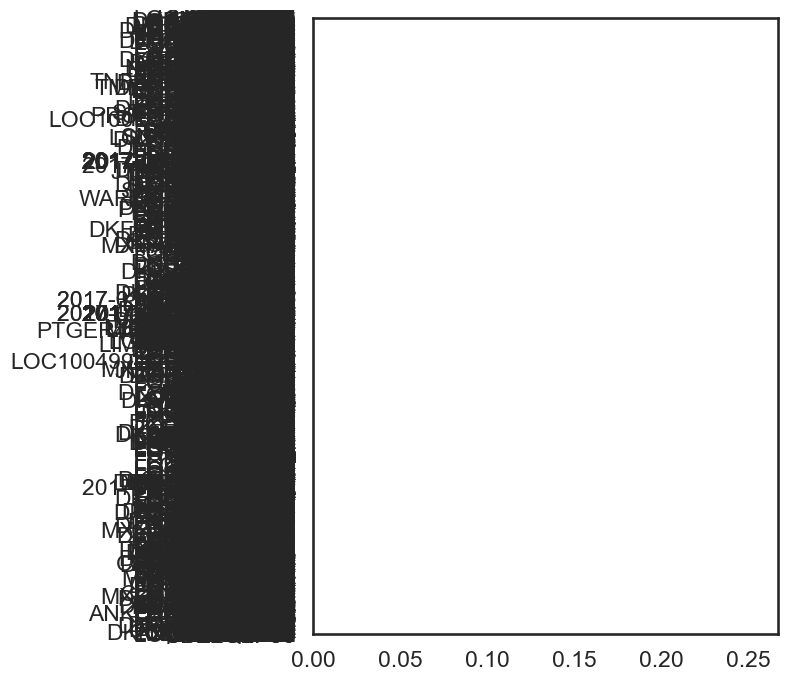

In [130]:
features = dt.drop(to_drop, axis=1).copy()
target = features.pop('Label')
X_norm = MinMaxScaler().fit_transform(features)
features[features.columns] = X_norm
importances = mutual_info_classif(features,target)
feat_importances = pd.Series(importances,features.columns[0:len(features.columns)])
feat_importances.plot(kind='barh',color='teal')
plt.show()

In [164]:
# feat_importances.sort_values(axis=0, ascending=False, inplace=False)[0:20]

In [193]:
features = dt[feat_importances.sort_values(axis=0, ascending=False, inplace=False)[0:10].index.to_list()
 + ['Label']].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_ig,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 53.90it/s]


In [207]:
models_ig.to_csv('ig.csv')

In [195]:
diff_1 = pd.merge(models_min_max,models_ig,left_index=True, right_index=True)
diff_1['diff'] = diff_1['F1 Score_y'] - diff_1['F1 Score_x']
diff_1['diff_1'] = abs(diff_1['F1 Score_y'] - diff_1['F1 Score_x'])
diff_1['diff_1'].mean()

0.21017548002546058

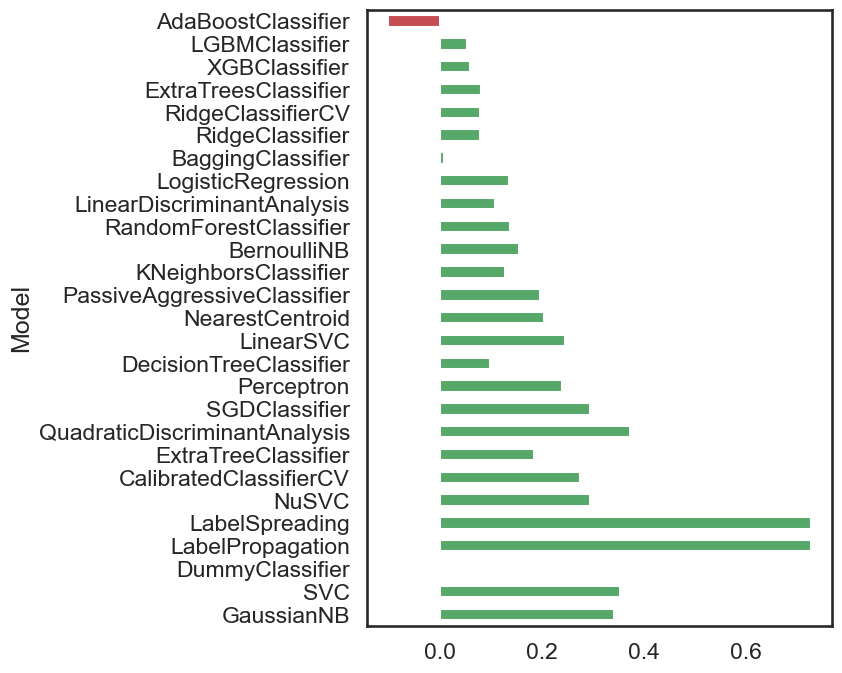

In [196]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,8)
diff_1.iloc[::-1]['diff'].plot(kind='barh',
                    color=(diff_1.iloc[::-1]['diff'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.savefig('information gain new.eps',bbox_inches = 'tight',dpi=1200,transparent= True, format='eps')

In [169]:
chi_feature

['CCDC154',
 'LOC100131650',
 'LOC101060339',
 'DDX51',
 'GUCA2B',
 'KRTAP10-12',
 'XRCC6P5',
 'LOC90784',
 'OR52I1',
 'TESSP5',
 'RETN',
 'SH3D2058',
 'SNORD89',
 'SPINK9',
 'FLJ45737',
 'STON1-GTF2A1L',
 'TMIGD1',
 'TREML4',
 'UBE2DNL',
 'WNT6']

In [170]:
feat_importances.sort_values(axis=0, ascending=False, inplace=False)[0:20].index.to_list()

['LOC90784',
 'LOC101060339',
 'XRCC6P5',
 'STON1-GTF2A1L',
 'EIF4G2',
 'LOC51240',
 'TREML4',
 'FBXL5',
 'SURF6',
 'FDX1L',
 'TMEM102',
 'DDX54',
 'YDJC',
 'OGFOD2',
 'LOC654184',
 'BTNL3',
 'ZNF786',
 'MFAP4',
 'SH3D203',
 'DKFZP779L1068']

In [81]:
def feat_select_info_gain(col):
    features = dt[col].copy()
    target = features.pop('Label')
    
    X_norm = MinMaxScaler().fit_transform(features)
    features[features.columns] = X_norm
    importances = mutual_info_classif(features,target)
    imp = pd.DataFrame(data = pd.Series(importances,features.columns[0:len(features.columns)])).reset_index()
    imp.columns = ['fields','importance']
    imp.sort_values(by='importance',axis=0, ascending=False, inplace=True)
    imp = pd.concat([imp[imp.importance <= imp[imp.importance < 0].importance.median()],
    imp[imp.importance >= imp[imp.importance > 0].importance.median()]],axis=0)
    print(f"{len(col)} columns produced max importance score of {imp.head(1).importance.values[0]}")
    return {
            'features': len(col),
            'cols':col,
            'medians': (imp[imp.importance < 0].importance.median(),imp[imp.importance > 0].importance.median()),
            'balanced_accuracy' :imp.head(1).importance.values[0],
            'next' : imp,
            'next_columns' : [x for x in imp.fields.values] + ['Label']
            }

In [82]:
# col = dt.columns
# features = dt[col].copy()
# target = features.pop('Label')

# X_norm = MinMaxScaler().fit_transform(features)
# features[features.columns] = X_norm
# importances = mutual_info_classif(features,target)
# imp = pd.DataFrame(data = pd.Series(importances,features.columns[0:len(features.columns)])).reset_index()
# imp.columns = ['fields','importance']
# imp.sort_values(by='importance',axis=0, ascending=False, inplace=True)
# imp

In [83]:
col = dt.drop(to_drop, axis=1).columns
features = [0,1]
result= []
while len(set(features[-5:])) != 1:
    res = feat_select_info_gain(col)
    result.append(res)
    features.append(res['features'])
    col = res['next_columns']

19620 columns produced max importance score of 0.25417202073310907
5411 columns produced max importance score of 0.25417202073310907
2593 columns produced max importance score of 0.25417202073310907
1289 columns produced max importance score of 0.25417202073310907
644 columns produced max importance score of 0.25417202073310907
323 columns produced max importance score of 0.25417202073310907
162 columns produced max importance score of 0.25417202073310907
82 columns produced max importance score of 0.25417202073310907
42 columns produced max importance score of 0.25417202073310907
22 columns produced max importance score of 0.25417202073310907
12 columns produced max importance score of 0.25417202073310907
7 columns produced max importance score of 0.25417202073310907
4 columns produced max importance score of 0.25417202073310907
3 columns produced max importance score of 0.25417202073310907
2 columns produced max importance score of 0.25417202073310907
2 columns produced max importanc

In [84]:
result

[{'features': 19620,
  'cols': Index(['Label', 'LOC100130426', 'UBE2Q2P30', 'UBE2Q2P31', 'LOC149767',
         'TIMM23', 'MOXD2', 'LOC155060', 'RNU12-2P', 'SSX9',
         ...
         'ZXDA', 'ZXDB', 'LOC100130182', 'ZYG11A', 'ZYG11B', 'ZYX', 'FLJ10821',
         'ZZZ3', 'HUMRTVLH3', 'AKR1C6P'],
        dtype='object', length=19620),
  'medians': (nan, 0.054262410617398005),
  'balanced_accuracy': 0.25417202073310907,
  'next':              fields  importance
  9795       LOC90784        0.25
  4156   LOC101060339        0.24
  9670        XRCC6P5        0.23
  5360         EIF4G2        0.19
  12195      LOC51240        0.18
  ...             ...         ...
  10392     LOC196204        0.03
  17877     LOC115125        0.03
  12232         OTOP2        0.03
  9249           LIPJ        0.03
  6928       GNAS-AS1        0.03
  
  [5410 rows x 2 columns],
  'next_columns': ['LOC90784',
   'LOC101060339',
   'XRCC6P5',
   'EIF4G2',
   'LOC51240',
   'TREML4',
   'OLFM3',
   'FBXL5',
  

In [ ]:
def modelling_mulitple(x_train, y_train):

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    f1_means,f1_std,tss_mean,tss_std,hss2_mean,hss2_std = [],[],[],[],[],[]

    classifiers = [LogisticRegression(random_state=random_state),DecisionTreeClassifier(random_state=random_state),
                  SVC(random_state=random_state),GaussianNB(),AdaBoostClassifier(random_state=random_state),
                    RandomForestClassifier(n_estimators=20,random_state=random_state),XGBClassifier()
                  ]

    scoring = {'f1_macro': 'f1_macro',
               'tss': tss_scorer,
               'hss2': hss2_scorer}

    for classifier in classifiers:
        print(classifier)
        scores = cross_validate(classifier, x_train, y_train, scoring=scoring, cv=cv)
        f1_means.append(scores['test_f1_macro'].mean())
        f1_std.append(scores['test_f1_macro'].std())
        tss_mean.append(scores['test_tss'].mean())
        tss_std.append(scores['test_tss'].std())
        hss2_mean.append(scores['test_hss2'].mean())
        hss2_std.append(scores['test_hss2'].std())

    cv_res = pd.DataFrame(data={'Algorithms':['LogisticRegression','DecisionTree','SVM','Naive Bayes','AdaBoost',
                                              'RandomForest','XGBoost'], 'F1 Mean Score':f1_means, 'F1 std':f1_std,
                               'TSS Mean Score':tss_mean, 'TSS std':tss_std, 'HSS2 Mean Score':hss2_mean, 'HSS2 std':hss2_std
                               })

    plt.rcParams["figure.figsize"] = [20.00, 6.00]
    plt.rcParams["figure.autolayout"] = True
    f, axes = plt.subplots(1, 3)

    sns.barplot(x = 'F1 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[0]).set(title='Cross Validation Scores')
    sns.barplot(x = 'TSS Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[1]).set(title='Cross Validation Scores')
    sns.barplot(x = 'HSS2 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[2]).set(title='Cross Validation Scores')

    plt.show()

    return cv_res

In [ ]:
## https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
## https://scikit-learn.org/stable/modules/feature_selection.html
## https://neptune.ai/blog/feature-selection-methods